<a href="https://colab.research.google.com/github/saumyasingh98/LeapmotionMLProject/blob/main/ML_ASL_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **All Imports**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.preprocessing import normalize

import keras
from keras.models import Sequential 
from keras.layers import Dense,Activation,Dropout 
from tensorflow.keras.layers import (
    BatchNormalization
)
from keras.utils import np_utils

### Loading the train and test data sets

In [ ]:
train = pd.read_csv('asl_stratified_train.csv', index_col=0)
test = pd.read_csv('asl_stratified_test.csv', index_col=0)
valid = pd.read_csv('asl_stratified_validation.csv', index_col=0)

In [ ]:
print(train.shape)
print(test.shape)
print(valid.shape)

(7000, 429)
(1500, 429)
(1499, 429)


In [ ]:
print(test.CLASS.value_counts())

<UNK>         728
DRINK          59
AIRPORT        57
BUS            52
YOU            51
FOOD           47
CAR            45
TIME           45
EXCUSE_ME      44
I              42
BAD            40
RESTAURANT     39
THANKS         38
NAME           38
TAXI           38
GOOD           38
SORRY          35
HELLO          34
PLANE          30
Name: CLASS, dtype: int64


### Correlation Heatmap for the 428 columns

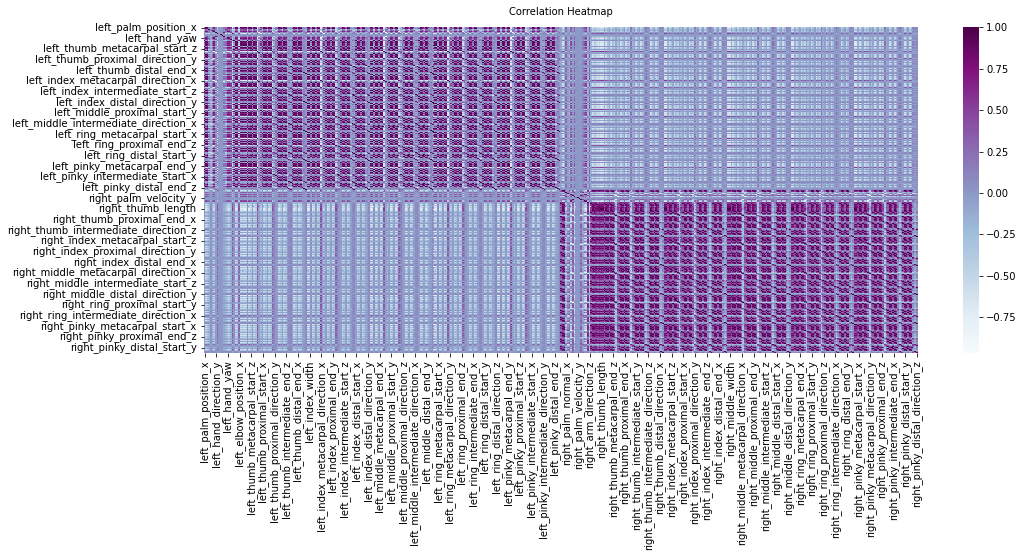

In [ ]:
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(train.iloc[:, :-1].corr(), cmap="BuPu")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=12);

In the above heat map we can see that there are high correlations internally between the left hand dimensions(upper left of the heatmap) and internally between the right hand dimensions (lower right of the heatmap).

This shows that there is a significant amount of correlation in-between the hands, where as there is less to no correlation between the hands.

### Heat Map - Left hand dimensions

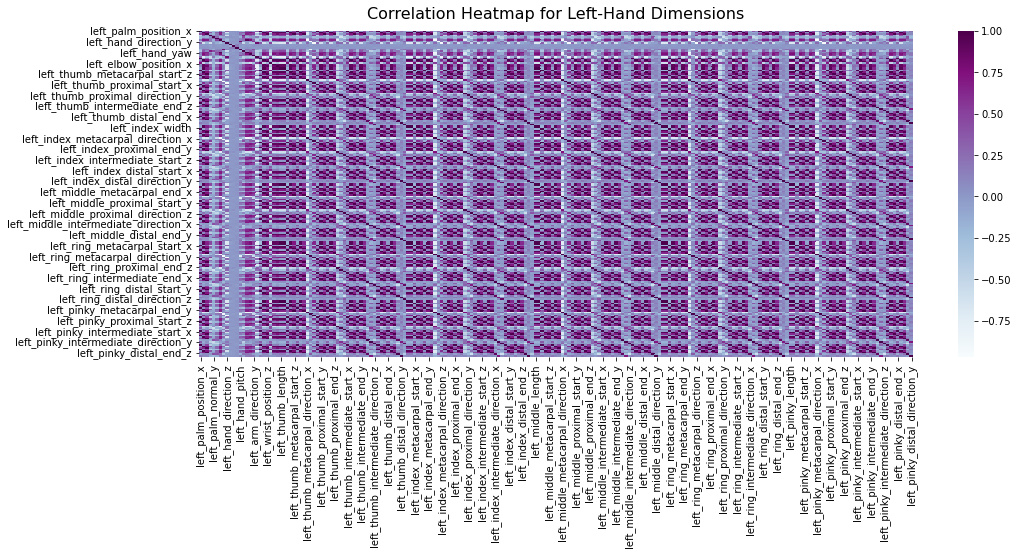

In [ ]:
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(train.iloc[: , :213].corr(), cmap="BuPu")
heatmap.set_title('Correlation Heatmap for Left-Hand Dimensions', fontdict={'fontsize':16}, pad=12);

### Heat Map - Right hand dimensions

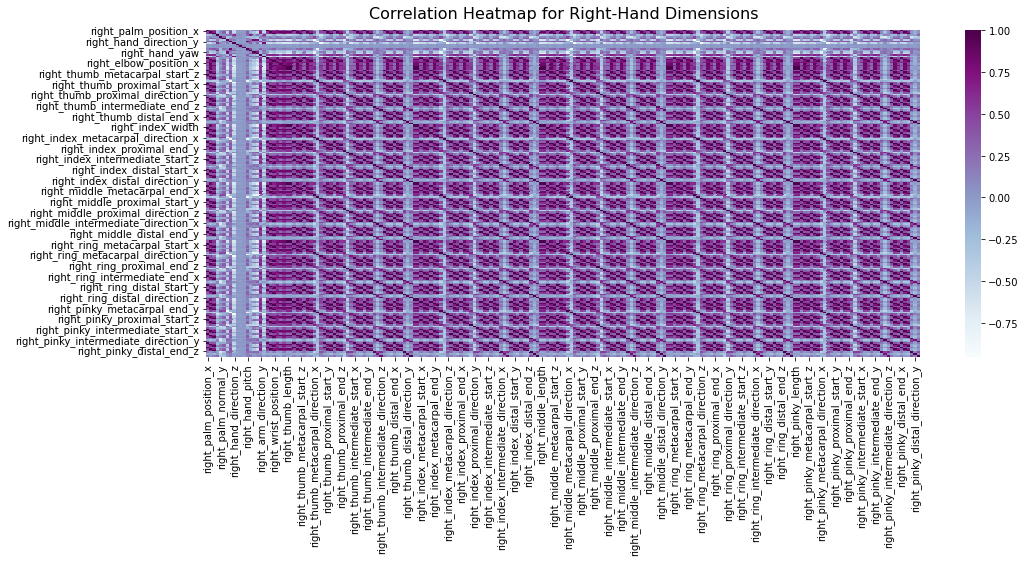

In [ ]:
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(train.iloc[: ,214:].corr(), cmap="BuPu")
heatmap.set_title('Correlation Heatmap for Right-Hand Dimensions', fontdict={'fontsize':16}, pad=12);

### Histograms of all left hand dimensions to see the general distributions

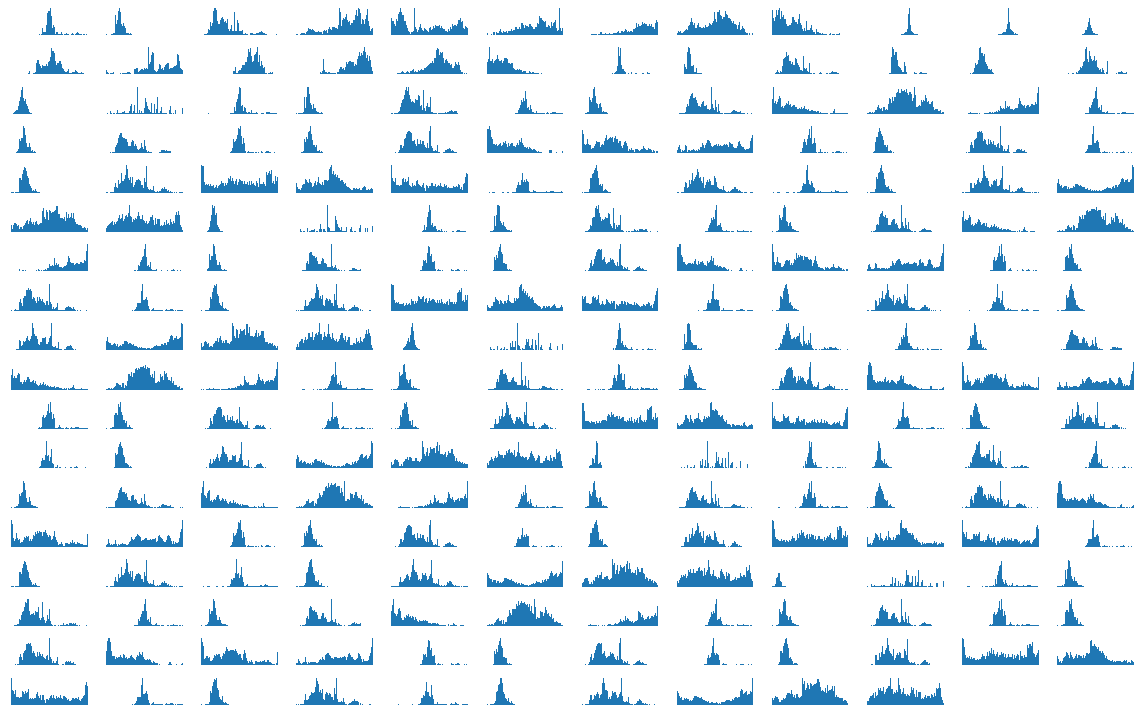

In [ ]:
fig, ax = plt.subplots(figsize = (16, 10))
for n, col in enumerate(train.iloc[: ,0:214].columns):
  plt.subplot(18, 12, n+1)
  train[train.iloc[:,n] != 0][col].hist(ax = plt.gca(), bins=100)
  plt.axis('off')
plt.tight_layout()

plt.savefig('left_hists.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

### Histograms of all right hand dimensions to see the general distributions

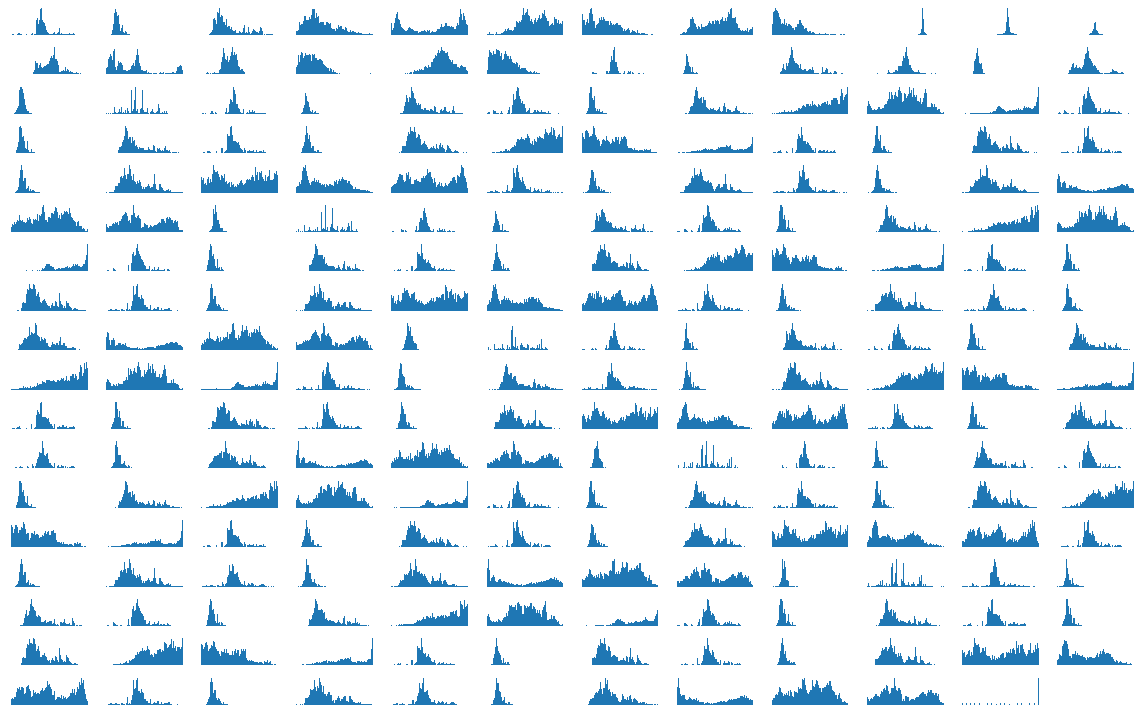

In [ ]:
fig, ax = plt.subplots(figsize = (16, 10))
for n, col in enumerate(train.iloc[: ,214:].columns):
  plt.subplot(18, 12, n+1)
  train[train.iloc[:,n+214] != 0][col].hist(ax = plt.gca(), bins=100)
  plt.axis('off')
plt.tight_layout()

plt.savefig('right_hists.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

### Observing that the scatter plots are majority gaussian distribution, normalizing the columns

In [ ]:
normalized_train = (train.iloc[:, :-1] - train.iloc[:, :-1].mean())/train.iloc[:, :-1].std()
train_means = train.iloc[:, :-1].mean()
train_sds = train.iloc[:, :-1].std()
print(normalized_train)

      left_palm_position_x  ...  right_pinky_distal_direction_z
118               0.085782  ...                       -1.502542
16                0.085782  ...                        0.452107
341              -0.811927  ...                        0.070553
270               0.085782  ...                        0.123291
37                1.215263  ...                        0.070553
...                    ...  ...                             ...
7121             -0.370683  ...                       -0.256330
6808              0.085782  ...                       -2.112305
6627             -0.202860  ...                       -0.545387
8336              0.085782  ...                       -1.393630
6241              0.085782  ...                       -0.297441

[7000 rows x 428 columns]


Normalizing the test data based on the train data

In [ ]:
normalized_test = (test.iloc[:, :-1] - train_means)/train_sds

print(normalized_test)

      left_palm_position_x  ...  right_pinky_distal_direction_z
7                 0.085782  ...                       -1.038328
13                0.681851  ...                        0.070553
14                0.777089  ...                        0.070553
19                0.085782  ...                        0.556003
20                0.085782  ...                       -1.630526
...                    ...  ...                             ...
7574             -0.354718  ...                       -0.253273
7585             -0.376284  ...                       -0.197893
7586             -0.377420  ...                       -0.181565
7589             -0.376322  ...                       -0.259825
7594             -0.357441  ...                       -0.240439

[1500 rows x 428 columns]


Normalizing the validation data based on the train data

In [ ]:
normalized_valid = (valid.iloc[:, :-1] - train_means)/train_sds

print(normalized_valid)

      left_palm_position_x  ...  right_pinky_distal_direction_z
199               0.085782  ...                        1.631360
202               0.085782  ...                        1.738550
209               0.085782  ...                        1.516795
210               0.085782  ...                        1.655184
217               0.085782  ...                        1.205809
...                    ...  ...                             ...
9989             -0.815281  ...                       -1.796815
9991             -0.866838  ...                       -1.880077
9995             -0.855976  ...                       -1.961058
9998             -0.847467  ...                       -1.924192
9999             -0.873490  ...                       -2.012741

[1499 rows x 428 columns]


### Post Normalized data histograms of all left hand dimensions to see the general distributions

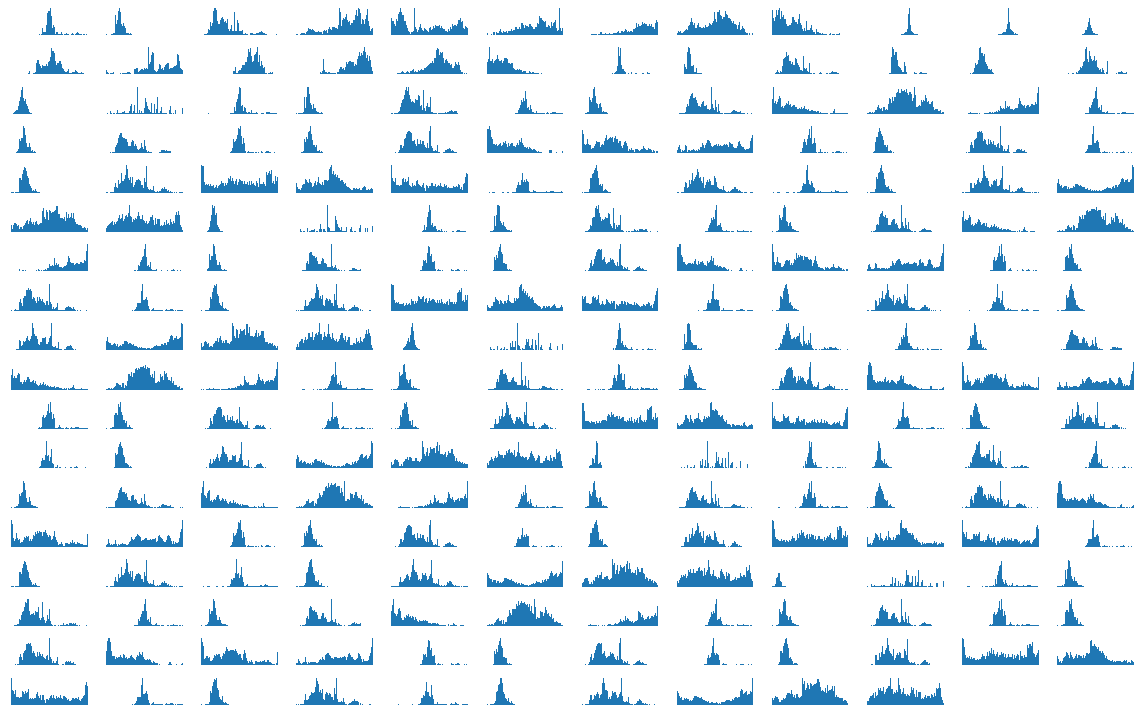

In [ ]:
fig, ax = plt.subplots(figsize = (16, 10))

for n, col in enumerate(normalized_train.iloc[: ,0:214].columns):
  temp_val = (0-train_means[n])/train_sds[n]
  plt.subplot(18, 12, n+1)
  normalized_train[normalized_train.iloc[:,n] != temp_val][col].hist(
      ax = plt.gca(),
      bins=100)
  plt.axis('off')

plt.tight_layout()

plt.savefig('left_normalized_hists.png', bbox_inches='tight', pad_inches = 0, 
            dpi = 200)

### Post Normalized data histograms of all right hand dimensions to see the general distributions

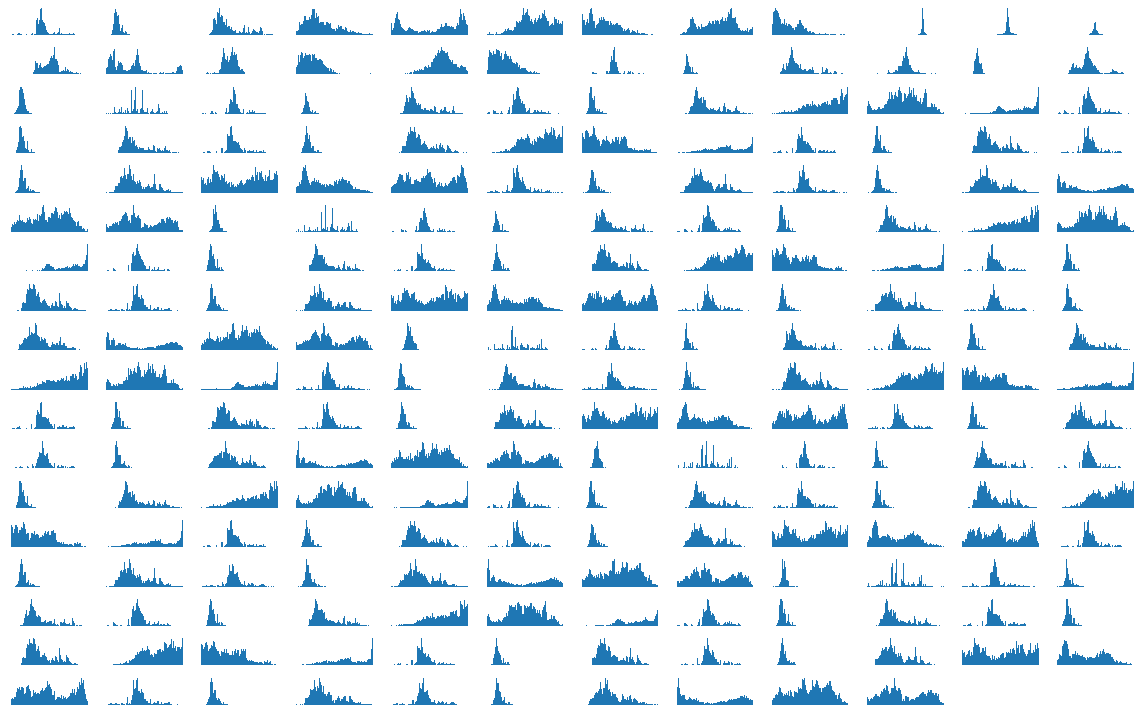

In [ ]:
fig, ax = plt.subplots(figsize = (16, 10))

for n, col in enumerate(normalized_train.iloc[: ,214:].columns):
  temp_val = (0-train_means[n+214])/train_sds[n+214]
  plt.subplot(18, 12, n+1)
  normalized_train[normalized_train.iloc[:,n+214] != temp_val][col].hist(
      ax = plt.gca(),
      bins=100)
  plt.axis('off')

plt.tight_layout()

plt.savefig('right_normalized_hists.png', bbox_inches='tight', pad_inches = 0, 
            dpi = 200)

### Creating the test-train and features-labels splits

In [ ]:
# Separating out the features
train_x = normalized_train.iloc[:, :428].values
# Separating out the target
train_y = train['CLASS']

# Separating out the features
test_x = normalized_test.iloc[:, :428].values
# Separating out the target
test_y = test['CLASS']

# Separating out the features
valid_x = normalized_valid.iloc[:, :428].values
# Separating out the target
valid_y = valid['CLASS']

### **Generating the Principal Components**

### Checking the ideal number of principal components

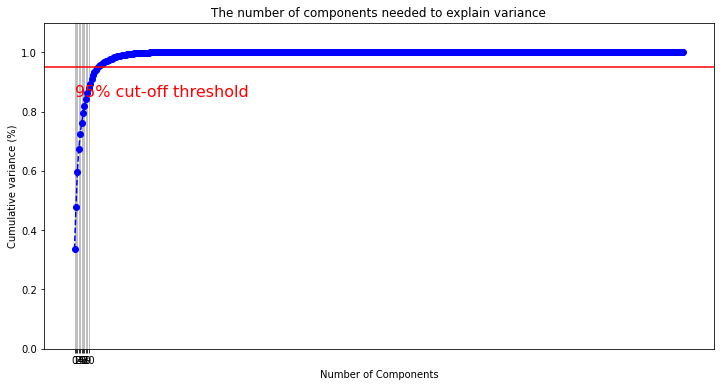

In [ ]:
pca = PCA().fit(train_x)

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(0, 428, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

### Building the principal components on the train and applying it on train and test datasets

In [ ]:
pca = PCA(n_components = 0.95)
pca.fit(train_x)
pca_train_x = pca.fit_transform(train_x)
pca_test_x = pca.transform(test_x)
pca_valid_x = pca.transform(valid_x)

In [ ]:
pca_train_x.shape

(7000, 18)

### Converting the numpy arrays from the PCA into pandas dataframe

In [ ]:
train_x_final = pd.DataFrame(
    pca_train_x, 
    columns = [ 'PC' + str(i) for i in range(pca_train_x.shape[1]) ]
    )

test_x_final = pd.DataFrame(
    pca_test_x, 
    columns = [ 'PC' + str(i) for i in range(pca_test_x.shape[1]) ]
    )

valid_x_final = pd.DataFrame(
    pca_valid_x, 
    columns = [ 'PC' + str(i) for i in range(pca_valid_x.shape[1]) ]
    )

## **k-Nearest Neighbours Modelling**

In [ ]:
num_of_classes = len(train['CLASS'].unique())

In [ ]:
## https://discuss.analyticsvidhya.com/t/how-to-choose-the-value-of-k-in-knn-algorithm/2606/12

num_neighbors = round(pca_train_x.shape[0]**0.5)

if num_neighbors % 2 == 0:
  num_neighbors = num_neighbors + 1
  if num_neighbors % num_of_classes == 0:
    num_neighbors = num_neighbors - 2
else:
  if num_neighbors % num_of_classes == 0:
    num_neighbors = num_neighbors + 1
    if num_neighbors % 2 == 0:
      num_neighbors = num_neighbors + 1

num_neighbors

85

In [ ]:
knn = KNeighborsClassifier(n_neighbors=num_neighbors, p=2, metric='euclidean')
knn.fit(train_x_final, train_y)

KNeighborsClassifier(metric='euclidean', n_neighbors=85)

In [ ]:
knn_preds = knn.predict(test_x_final)

In [ ]:
knn_cm = confusion_matrix(test_y, knn_preds)
print(knn_cm)

[[662   6   9   7   2   2   0   7   0   7   3   1   0   0   1  12   0   7
    2]
 [ 15  37   0   0   0   0   0   1   0   0   1   1   0   2   0   0   0   0
    0]
 [  6   2  29   0   0   1   0   0   2   0   0   0   0   0   0   0   0   0
    0]
 [  4   0   1  47   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  2   0   0   1  40   2   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [ 19   0   4   0   0  33   0   0   1   0   0   0   2   0   0   0   0   0
    0]
 [  4   0   0   0   1   8  31   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  9   3   1   0   0   0   0  26   0   0   0   0   0   0   7   0   1   0
    0]
 [  2   0   1   0   0   2   4   0  29   0   0   0   0   0   0   0   0   0
    0]
 [ 25   0   0   0   0   0   0   0   0   8   0   0   1   0   0   0   0   0
    0]
 [  8   0   1   0   0   0   0   0   0   0  30   0   0   0   0   1   0   0
    2]
 [  5   1   0   3   0   0   0   1   3   0   0  21   0   1   0   3   0   0
    0]
 [ 12   8   5   0   0   1   

In [ ]:
print(f1_score(test_y, knn_preds, average='macro'))
print(f1_score(test_y, knn_preds, average='weighted'))

print(accuracy_score(test_y, knn_preds))

0.6350289925597221
0.7380090691110831
0.7546666666666667


## **Support Vector Machines Modelling**

In [ ]:
svm=SVC()
svm.fit(train_x_final, train_y)

SVC()

In [ ]:
svm_preds = svm.predict(test_x_final)

In [ ]:
svm_cm = confusion_matrix(test_y, svm_preds)
print(svm_cm)

[[712   3   3   0   0   0   0   8   0   0   0   0   0   1   0   0   0   0
    1]
 [ 10  39   0   0   0   0   0   1   1   0   0   0   2   1   0   3   0   0
    0]
 [  8   0  28   0   0   2   0   0   2   0   0   0   0   0   0   0   0   0
    0]
 [  5   0   0  47   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  2   0   0   1  40   0   0   0   2   0   0   0   0   0   0   0   0   0
    0]
 [ 17   0   1   0   0  39   0   0   1   0   0   0   0   0   0   1   0   0
    0]
 [  6   0   2   0   0   0  36   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  5   0   0   0   0   0   0  40   0   0   0   0   0   2   0   0   0   0
    0]
 [  3   0   0   0   0   0   2   0  33   0   0   0   0   0   0   0   0   0
    0]
 [ 30   0   0   0   0   0   0   0   0   4   0   0   0   0   0   0   0   0
    0]
 [  7   0   1   0   0   0   0   0   0   0  34   0   0   0   0   0   0   0
    0]
 [  3   0   0   1   0   0   0   1   0   0   0  32   0   1   0   0   0   0
    0]
 [ 10   0   5   0   0   0   

In [ ]:
print(f1_score(test_y, svm_preds, average='macro'))
print(f1_score(test_y, svm_preds, average='weighted'))

print(accuracy_score(test_y, svm_preds))

0.7688948582955478
0.828658724427298
0.8433333333333334


## **Multinomial Logistic Regression Modelling**

In [ ]:
mnlr = LogisticRegression(multi_class='multinomial',solver='newton-cg',random_state = 0)
mnlr.fit(train_x_final, train_y)

LogisticRegression(multi_class='multinomial', random_state=0,
                   solver='newton-cg')

In [ ]:
#print the tunable parameters (They were not tuned in this example, everything kept as default)
params = mnlr.get_params()
print(params)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': None, 'penalty': 'l2', 'random_state': 0, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [ ]:
#Print model parameters
print('Intercept: \n', mnlr.intercept_)
print('Coefficients: \n', mnlr.coef_)

Intercept: 
 [  8.31600785   4.69774933  -3.88789799  -5.13571615   2.10266592
  -0.53790608   0.18315388   2.65520206   2.72327133  -1.80014508
   0.69292776 -21.50650986  -1.79677031   2.97999296   3.33166022
   3.28898565   0.42630901   1.06488327   2.20213624]
Coefficients: 
 [[-9.24013201e-03 -1.58812607e-02 -5.75284668e-02  1.35865041e-01
   7.00872033e-03 -1.08377186e-01  1.86564683e-01 -1.68929957e-01
   3.56235698e-01  3.32706658e-01 -1.95822143e-01 -4.12048991e-02
   1.16880699e-01  2.53372185e-01  2.83530586e-01 -5.00288507e-01
   3.84876946e-01  1.95431740e-01]
 [-2.15256633e-03  2.69501180e-02 -1.23878241e-01  1.32106191e-01
   1.89763288e-02  8.86155081e-02 -6.36873419e-03 -1.43944233e-02
  -1.96015199e-01 -4.88322515e-02 -4.76746476e-02  1.66236241e-01
   3.53520280e-01  2.86980444e-01  2.24119370e-01 -3.15520177e-01
   9.68787001e-01  1.30364320e-01]
 [ 7.33225979e-01 -2.63926960e-01 -2.14575781e-01 -1.04269584e-01
  -4.75950081e-01  3.54295430e-01  7.28083243e-01 -4.01

In [ ]:
mnlr_preds = mnlr.predict(test_x_final)

In [ ]:
mnlr_cm = confusion_matrix(test_y, mnlr_preds)
print(mnlr_cm)

[[666   4   0   2   2   2   0   6   7   8   2   2   1   8   2   5   0   8
    3]
 [  8  14   0   0   0   0   0  17   0   0   3   2   4   3   1   3   0   1
    1]
 [ 21   0  12   0   0   3   0   0   2   0   0   0   0   2   0   0   0   0
    0]
 [  2   0   0  46   0   1   0   0   0   1   0   0   1   0   0   0   0   0
    1]
 [  1   0   0   0  40   0   2   0   0   2   0   0   0   0   0   0   0   0
    0]
 [ 44   0   0   0   0  14   0   0   1   0   0   0   0   0   0   0   0   0
    0]
 [  3   0   0   0   0   5  34   0   1   1   0   0   0   0   0   0   0   0
    0]
 [ 23   0   0   0   0   0   0  13   0   0   0   0   0   4   6   0   0   1
    0]
 [  8   0   2   0   0   1   1   0  24   0   0   0   1   1   0   0   0   0
    0]
 [ 25   0   0   0   0   1   0   0   0   8   0   0   0   0   0   0   0   0
    0]
 [  6   0   0   0   0   0   0   1   1   0  25   0   0   2   5   0   0   0
    2]
 [ 13   1   0   0   0   0   0   0   3   0   0  17   0   1   1   0   0   0
    2]
 [ 14   0   5   0   0   1   

In [ ]:
print(f1_score(test_y, mnlr_preds, average='macro'))
print(f1_score(test_y, mnlr_preds, average='weighted'))

print(accuracy_score(test_y, mnlr_preds))

0.5609120016060531
0.6787027029380368
0.7033333333333334


## **Random Forests Modelling**

In [ ]:
rf=RandomForestClassifier(n_estimators=100)
rf.fit(train_x_final, train_y)

RandomForestClassifier()

In [ ]:
rf_preds=rf.predict(test_x_final)

In [ ]:
rf_cm = confusion_matrix(test_y, rf_preds)
print(rf_cm)

[[722   1   0   0   0   0   0   0   0   3   0   0   0   0   0   1   0   0
    1]
 [  9  46   0   0   0   0   0   0   0   0   0   0   1   0   0   1   0   0
    0]
 [  2   0  36   0   0   1   0   0   0   0   0   0   0   0   0   1   0   0
    0]
 [  4   0   0  48   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  2   0   0   0  41   0   0   0   2   0   0   0   0   0   0   0   0   0
    0]
 [  7   0   0   0   0  49   0   0   1   1   0   0   0   0   0   1   0   0
    0]
 [  6   0   0   0   0   0  38   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  6   0   0   0   0   0   0  40   0   0   0   0   0   1   0   0   0   0
    0]
 [  2   0   0   0   0   0   0   0  35   0   0   0   0   0   1   0   0   0
    0]
 [ 12   0   0   0   0   0   0   0   0  22   0   0   0   0   0   0   0   0
    0]
 [  9   0   1   0   0   0   0   0   0   0  32   0   0   0   0   0   0   0
    0]
 [  3   0   0   0   0   0   0   0   1   0   0  34   0   0   0   0   0   0
    0]
 [  2   0   3   0   0   0   

In [ ]:
print(f1_score(test_y, rf_preds, average='macro'))
print(f1_score(test_y, rf_preds, average='weighted'))

print(accuracy_score(test_y, rf_preds))

0.8871470272515947
0.9128003128584532
0.9146666666666666


## **Gaussian Naive Bayes Modelling**

In [ ]:
nb = GaussianNB()
nb.fit(train_x_final, train_y)

GaussianNB()

In [ ]:
nb_preds = nb.predict(test_x_final)

In [ ]:
nb_cm = confusion_matrix(test_y, nb_preds)
print(nb_cm)

[[527  11  50   0   1  12   3   7   5  33   3  27   4  13   0   9   0  19
    4]
 [  5  11   4   0   0   0   0   3   1   0   0   2   0   8   0   3   0  20
    0]
 [  1   0  37   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2
    0]
 [  3   0   0  42   0   0   0   0   0   0   0   0   2   1   0   4   0   0
    0]
 [  2   0   1   0  40   0   0   0   0   1   0   0   0   1   0   0   0   0
    0]
 [ 10   0  25   0   0  22   0   0   0   1   0   0   0   0   0   1   0   0
    0]
 [  2   0   6   0   0   0  31   0   1   1   0   0   0   1   0   2   0   0
    0]
 [  6   3   4   0   0   0   0  28   0   0   0   0   0   2   2   0   0   2
    0]
 [  0   0  25   0   0   1   0   0   9   0   0   0   0   1   0   2   0   0
    0]
 [ 18   0  11   0   0   0   0   0   0   4   0   0   1   0   0   0   0   0
    0]
 [  6   0   1   0   0   0   0   0   1   1  26   0   0   4   3   0   0   0
    0]
 [  1   1   0   2   0   0   0   0   1   0   0  25   0   3   0   4   0   0
    1]
 [  3   0  25   0   0   0   

In [ ]:
print(f1_score(test_y, nb_preds, average='macro'))
print(f1_score(test_y, nb_preds, average='weighted'))

print(accuracy_score(test_y, nb_preds))

0.4693337183035629
0.6208696234586422
0.5946666666666667


## **Neural Networks Modelling**

In [ ]:
classes = train.CLASS.unique()

train_y_nn = train.CLASS
test_y_nn = test.CLASS

for i in range(len(classes)):
  train_y_nn[train_y_nn == classes[i]] = i
  test_y_nn[test_y_nn == classes[i]] = i

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train_y_nn = np_utils.to_categorical(train_y_nn, num_classes=19)
test_y_nn = np_utils.to_categorical(test_y_nn, num_classes=19)

In [ ]:
nn = Sequential()
nn.add(Dense(1024, input_dim = 18, activation = 'relu'))
nn.add(Dropout(0.2))
nn.add(Dense(19, activation = 'softmax'))
nn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['ce'])

In [ ]:
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              19456     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 19)                19475     
                                                                 
Total params: 38,931
Trainable params: 38,931
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nn.fit(
    train_x_final, train_y_nn, 
    validation_data = (test_x_final, test_y_nn), 
    batch_size=50, 
    epochs=100, 
    verbose=1
    )

Epoch 1/100
140/140 [==============================] - 1s 5ms/step - loss: 0.9630 - ce: 0.9630 - val_loss: 0.7571 - val_ce: 0.7571
Epoch 2/100
140/140 [==============================] - 1s 4ms/step - loss: 0.5318 - ce: 0.5318 - val_loss: 0.6233 - val_ce: 0.6233
Epoch 3/100
140/140 [==============================] - 0s 3ms/step - loss: 0.4308 - ce: 0.4308 - val_loss: 0.5409 - val_ce: 0.5409
Epoch 4/100
140/140 [==============================] - 0s 3ms/step - loss: 0.3703 - ce: 0.3703 - val_loss: 0.4924 - val_ce: 0.4924
Epoch 5/100
140/140 [==============================] - 0s 3ms/step - loss: 0.3322 - ce: 0.3322 - val_loss: 0.4646 - val_ce: 0.4646
Epoch 6/100
140/140 [==============================] - 0s 3ms/step - loss: 0.2950 - ce: 0.2950 - val_loss: 0.4341 - val_ce: 0.4341
Epoch 7/100
140/140 [==============================] - 0s 3ms/step - loss: 0.2757 - ce: 0.2757 - val_loss: 0.4446 - val_ce: 0.4446
Epoch 8/100
140/140 [==============================] - 0s 3ms/step - loss: 0.2520 -

In [ ]:
nn_test_preds_full = nn.predict(test_x_final)
nn_pred_length = len(nn_test_preds_full)
test_y = np.argmax(test_y_nn, axis=1)
nn_test_preds = np.argmax(nn_test_preds_full, axis=1)

In [ ]:
nn_cm = confusion_matrix(test_y, nn_test_preds)
print(nn_cm)

NameError: ignored

In [ ]:
print(f1_score(test_y, nn_test_preds, average='macro'))
print(f1_score(test_y, nn_test_preds, average='weighted'))

print(accuracy_score(test_y, nn_test_preds))

0.9038359295085275
0.934402113938913
0.9333333333333333


## **Validation Data Metrics**

In [ ]:
knn_valid_preds = knn.predict(valid_x_final)

print(f1_score(valid_y, knn_valid_preds, average='macro'))
print(f1_score(valid_y, knn_valid_preds, average='weighted'))

print(accuracy_score(valid_y, knn_valid_preds))

0.6807813604180734
0.7774121659920648
0.7971981320880587


In [ ]:
svm_valid_preds = svm.predict(valid_x_final)

print(f1_score(valid_y, svm_valid_preds, average='macro'))
print(f1_score(valid_y, svm_valid_preds, average='weighted'))

print(accuracy_score(valid_y, svm_valid_preds))

0.8823733467120348
0.9019975969057754
0.9086057371581054


In [ ]:
mnlr_valid_preds = mnlr.predict(valid_x_final)

print(f1_score(valid_y, mnlr_valid_preds, average='macro'))
print(f1_score(valid_y, mnlr_valid_preds, average='weighted'))

print(accuracy_score(valid_y, mnlr_valid_preds))

0.6846208835923653
0.7569096154004021
0.781187458305537


In [ ]:
rf_valid_preds=rf.predict(valid_x_final)

print(f1_score(valid_y, rf_valid_preds, average='macro'))
print(f1_score(valid_y, rf_valid_preds, average='weighted'))

print(accuracy_score(valid_y, rf_valid_preds))

0.9374929719865489
0.9491363739426619
0.9506337558372249


In [ ]:
nb_valid_preds = nb.predict(valid_x_final)

print(f1_score(valid_y, nb_valid_preds, average='macro'))
print(f1_score(valid_y, nb_valid_preds, average='weighted'))

print(accuracy_score(valid_y, nb_valid_preds))

0.5393536311885911
0.6224382489364357
0.6170780520346898


In [ ]:
valid_y_nn = valid.CLASS

for i in range(len(classes)):
  valid_y_nn[valid_y_nn == classes[i]] = i

valid_y_nn = np_utils.to_categorical(valid_y_nn, num_classes=19)

nn_valid_preds_full = nn.predict(valid_x_final)
nn_valid_pred_length = len(nn_valid_preds_full)
valid_y = np.argmax(valid_y_nn, axis=1)
nn_valid_preds = np.argmax(nn_valid_preds_full, axis=1)

print(f1_score(valid_y, nn_valid_preds, average='macro'))
print(f1_score(valid_y, nn_valid_preds, average='weighted'))

print(accuracy_score(valid_y, nn_valid_preds))

0.937394228820787
0.9584186593444083
0.9586390927284857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
